## ANALYSIS EXPERIMENT 2.1 (GPT2-SMALL) - Updates plots_exp_2_1.ipynb



Context: 

This experiment (2.1 with B) replaces the incomplete experiment 2.1, with the "Spec B" placement strategy (corresponds to Specific in the paper). It deprecated the "busy_H_spec" (General History - "A" (old knowledge))

- This experiment was run with the code `exp_2_1_with_B.py` and `gpt2-small_experiment2_1_with_B.yml` configuration file.
- We've been using the terminology History (H); (A) and (B) in sequential (incremental or editing) learning tasks. Unfortunately the terminology remained in the code for historical reasons, and is different from what is in the paper. 

- The experiment goes like this: 
    * General training on 10k facts (warm up on "H") (this is useful for the "lottery ticket" hypothesis: i.e. it turned out that  placing in this space is useful)
    * Followed by -> Train on "A" 2k facts (old knowledge) 
    * Followed by -> Train on "B" 1k facts (new knowledge) trying different placement strategies. 

- what we care about here is the performance on new and old knowledge as a function of the placement strategy.

## 1. Incremental learning on gpt2 small.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


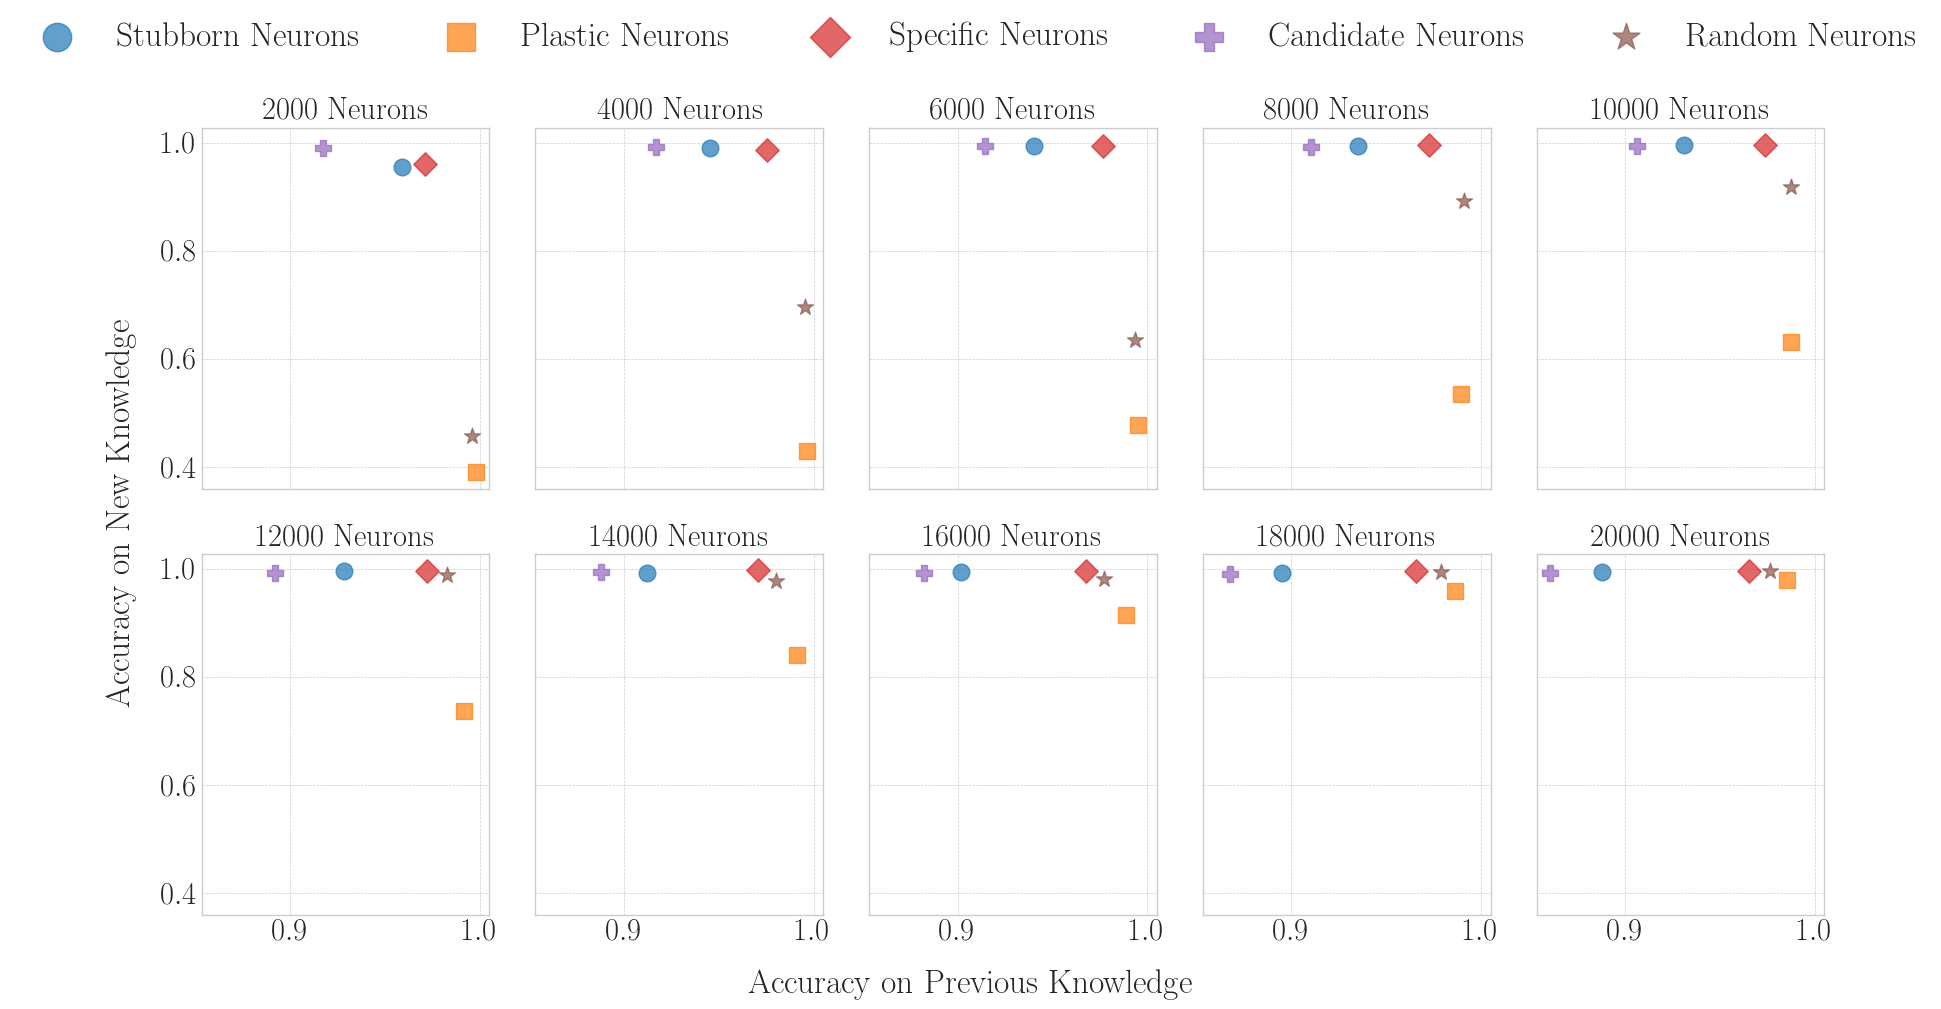

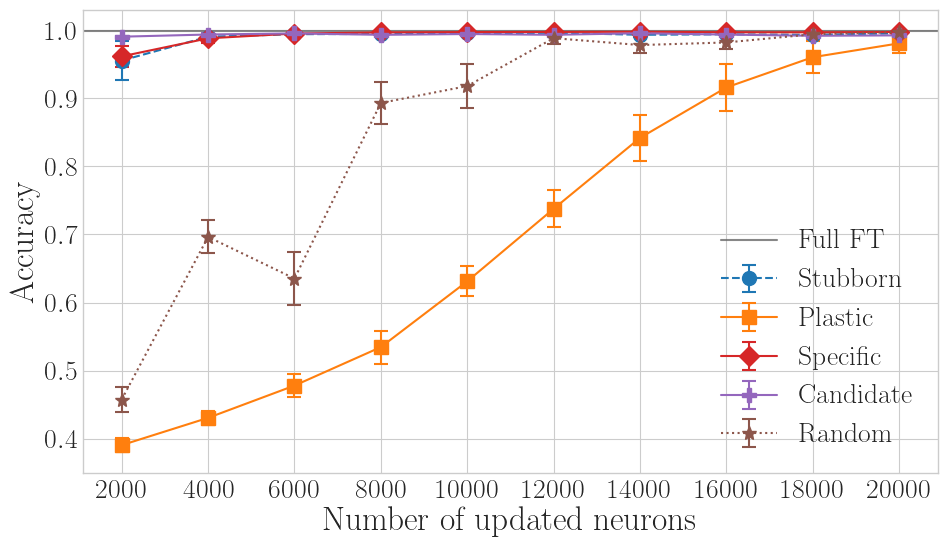

In [4]:
%load_ext autoreload
%autoreload 2

from retained_plots import plot_pareto_mosaic, plot_old_new_knowledge_all,plot_new_knowledge_all_long_legend

experiment_name = 'experiment2_1_withB'
filepath = '../experiments/gpt2-small/experiment_2_1/results/'
filename = 'experiment_2_1_with_B_20240720_011953.json'

plot_pareto_mosaic(filepath, filename, experiment_name=experiment_name, strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'])
plot_old_new_knowledge_all(filepath, filename, experiment_name, strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'], loc_old='lower left', bbox_old=(0,-0.05),loc_new='lower right', bbox_new=(1,0), y_lim_old_1=0.7, y_lim_old_2=1.02)

## 2. Old visulization tryouts

### Data preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import importlib
import os
import pickle

import sys
# custom path insertion
sys.path.append(os.path.abspath('..'))

import utils 
importlib.reload(utils)

experiment_name = 'experiment2_1_withB'

from utils import *

# Set up the plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (8, 10)
})

with open('../experiments/gpt2-small/experiment_2_1/results/experiment_2_1_with_B_20240720_011953.json', 'r') as file: 
    data = json.load(file)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Configure Seaborn for better aesthetics
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Assuming `data` contains the experimental data
n_folds = len(data['results'].keys())
thresholds = [int(t) for t in list(next(iter(data['results'].values()))['cftb'].keys())]

# Initialize accumulators
strategies = ['busy_A', 'free_A', 'busy_H_spec', 'spec_B', 'busy_B', 'rnd']
strategy_labels = {
    'busy_A': 'Busy Neurons',
    'free_A': 'Free Neurons',
    'busy_H_spec': 'Specific Neurons (General)',
    'spec_B': 'Specific Neurons (New)',
    'busy_B': 'New Neurons (New)',
    'rnd': 'Sparse Neurons (Random)'
}

# Initialize dictionaries to store results
results = {strategy: {'acc_A': [], 'acc_B': [], 'std_acc_A': [], 'std_acc_B': []} for strategy in strategies}

# Baselines
fta_accA = []
ftb_accA = []
ftb_accB = []

# Aggregate results across folds
for fold in data['results'].values():
    fta_accA.append(fold['fta']['acc_A'])
    ftb_accA.append(fold['ftb']['avg_accA'])
    ftb_accB.append(fold['ftb']['avg_accB'])
    
    for strategy in strategies:
        acc_A = []
        acc_B = []
        for t in thresholds:
            acc_A.append(fold['cftb'][str(t)][strategy]['avg_accA'])
            acc_B.append(fold['cftb'][str(t)][strategy]['avg_accB'])
        results[strategy]['acc_A'].append(acc_A)
        results[strategy]['acc_B'].append(acc_B)

# Compute means and standard deviations
for strategy in strategies:
    results[strategy]['mean_acc_A'] = np.mean(results[strategy]['acc_A'], axis=0)
    results[strategy]['mean_acc_B'] = np.mean(results[strategy]['acc_B'], axis=0)
    results[strategy]['std_acc_A'] = np.std(results[strategy]['acc_A'], axis=0)
    results[strategy]['std_acc_B'] = np.std(results[strategy]['acc_B'], axis=0)

# Baseline means
fta_accA_mean = np.mean(fta_accA)
ftb_accA_mean = np.mean(ftb_accA)
ftb_accB_mean = np.mean(ftb_accB)

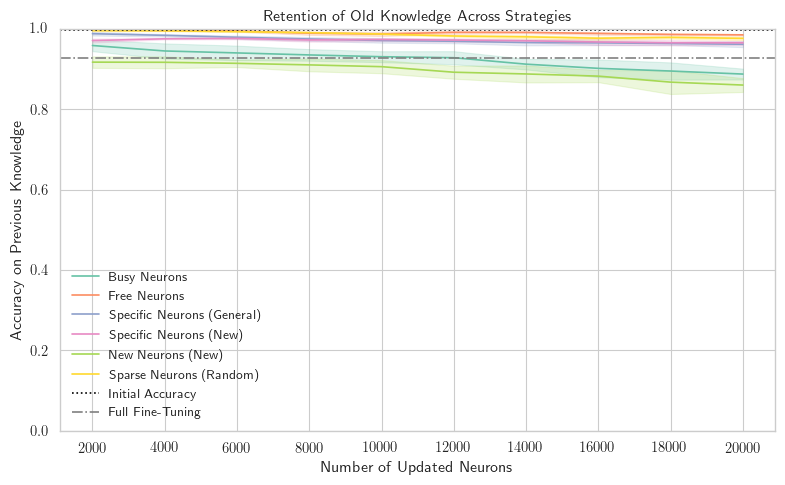

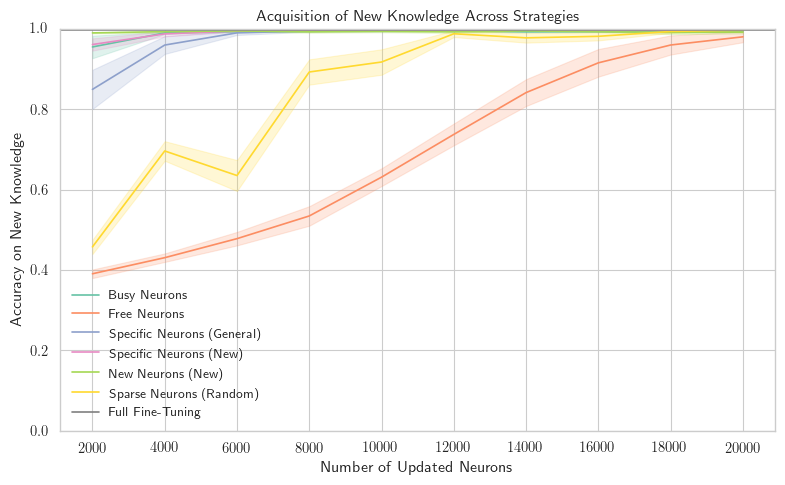

In [18]:
# Plot for Old Knowledge Accuracy
plt.figure(figsize=(8, 5))

for idx, strategy in enumerate(strategies):
    plt.plot(thresholds, results[strategy]['mean_acc_A'], label=strategy_labels[strategy], color=palette[idx])
    plt.fill_between(thresholds,
                     results[strategy]['mean_acc_A'] - results[strategy]['std_acc_A'],
                     results[strategy]['mean_acc_A'] + results[strategy]['std_acc_A'],
                     color=palette[idx], alpha=0.2)

# Baselines
plt.axhline(y=fta_accA_mean, color='black', linestyle=':', label='Initial Accuracy')
plt.axhline(y=ftb_accA_mean, color='grey', linestyle='-.', label='Full Fine-Tuning')

plt.xlabel('Number of Updated Neurons')
plt.ylabel('Accuracy on Previous Knowledge')
plt.title('Retention of Old Knowledge Across Strategies')
plt.xticks(thresholds)
plt.ylim(0, 1)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

# Plot for New Knowledge Accuracy
plt.figure(figsize=(8, 5))

for idx, strategy in enumerate(strategies):
    plt.plot(thresholds, results[strategy]['mean_acc_B'], label=strategy_labels[strategy], color=palette[idx])
    plt.fill_between(thresholds,
                     results[strategy]['mean_acc_B'] - results[strategy]['std_acc_B'],
                     results[strategy]['mean_acc_B'] + results[strategy]['std_acc_B'],
                     color=palette[idx], alpha=0.2)

# Baseline
plt.axhline(y=ftb_accB_mean, color='grey', linestyle='-', label='Full Fine-Tuning')

plt.xlabel('Number of Updated Neurons')
plt.ylabel('Accuracy on New Knowledge')
plt.title('Acquisition of New Knowledge Across Strategies')
plt.xticks(thresholds)
plt.ylim(0, 1)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()

###  "Pareto" scatter 

####  Unreadable when putting all updated neurons

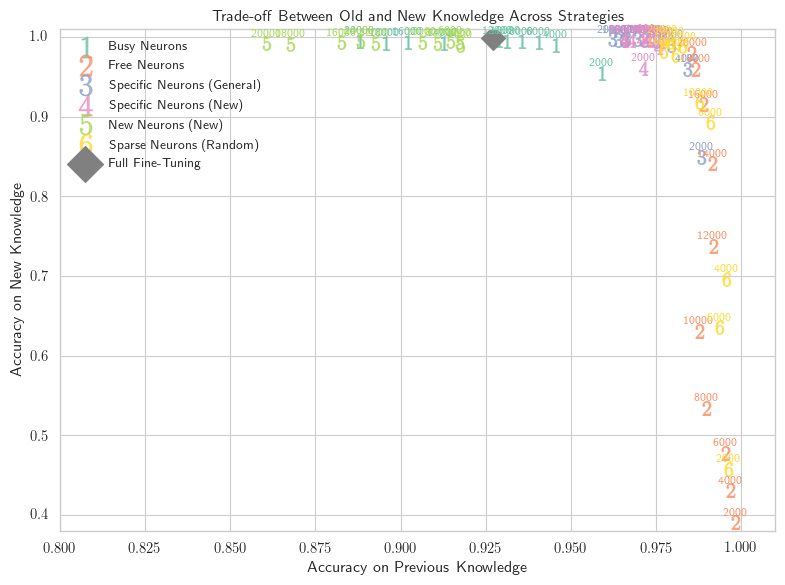

In [19]:
import matplotlib.pyplot as plt

# Assume data has already been processed as in previous steps

plt.figure(figsize=(8, 6))

# Define a color palette
palette = sns.color_palette("Set2", n_colors=len(strategies))

# Scatter plot with different shapes and increased point size
for idx, strategy in enumerate(strategies):
    plt.scatter(results[strategy]['mean_acc_A'], results[strategy]['mean_acc_B'], 
                label=strategy_labels[strategy], color=palette[idx],
                s=100, alpha=0.7, marker=f"${idx+1}$")  # Use numbers as markers for differentiation

    # Annotate points with number of neurons, with slight offset
    for i, neurons in enumerate(thresholds):
        plt.annotate(f'{neurons}', 
                     (results[strategy]['mean_acc_A'][i], results[strategy]['mean_acc_B'][i]),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color=palette[idx])

# Highlight the baselines with distinct markers
#plt.scatter(fta_accA_mean, 0, color='black', marker='X', s=150, label='Initial Accuracy')
plt.scatter(ftb_accA_mean, ftb_accB_mean, color='grey', marker='D', s=150, label='Full Fine-Tuning')

# Adjust axis limits for better visibility
plt.xlim(0.8, 1.01)  # Slightly expand limits to give points more space
plt.ylim(0.38, 1.01)

# Label axes and set title
plt.xlabel('Accuracy on Previous Knowledge')
plt.ylabel('Accuracy on New Knowledge')
plt.title('Trade-off Between Old and New Knowledge Across Strategies')

# Improve the legend
plt.legend(loc='upper left', fontsize='small', markerscale=1.5)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
strategies

['busy_A', 'free_A', 'busy_H_spec', 'spec_B', 'busy_B', 'rnd']

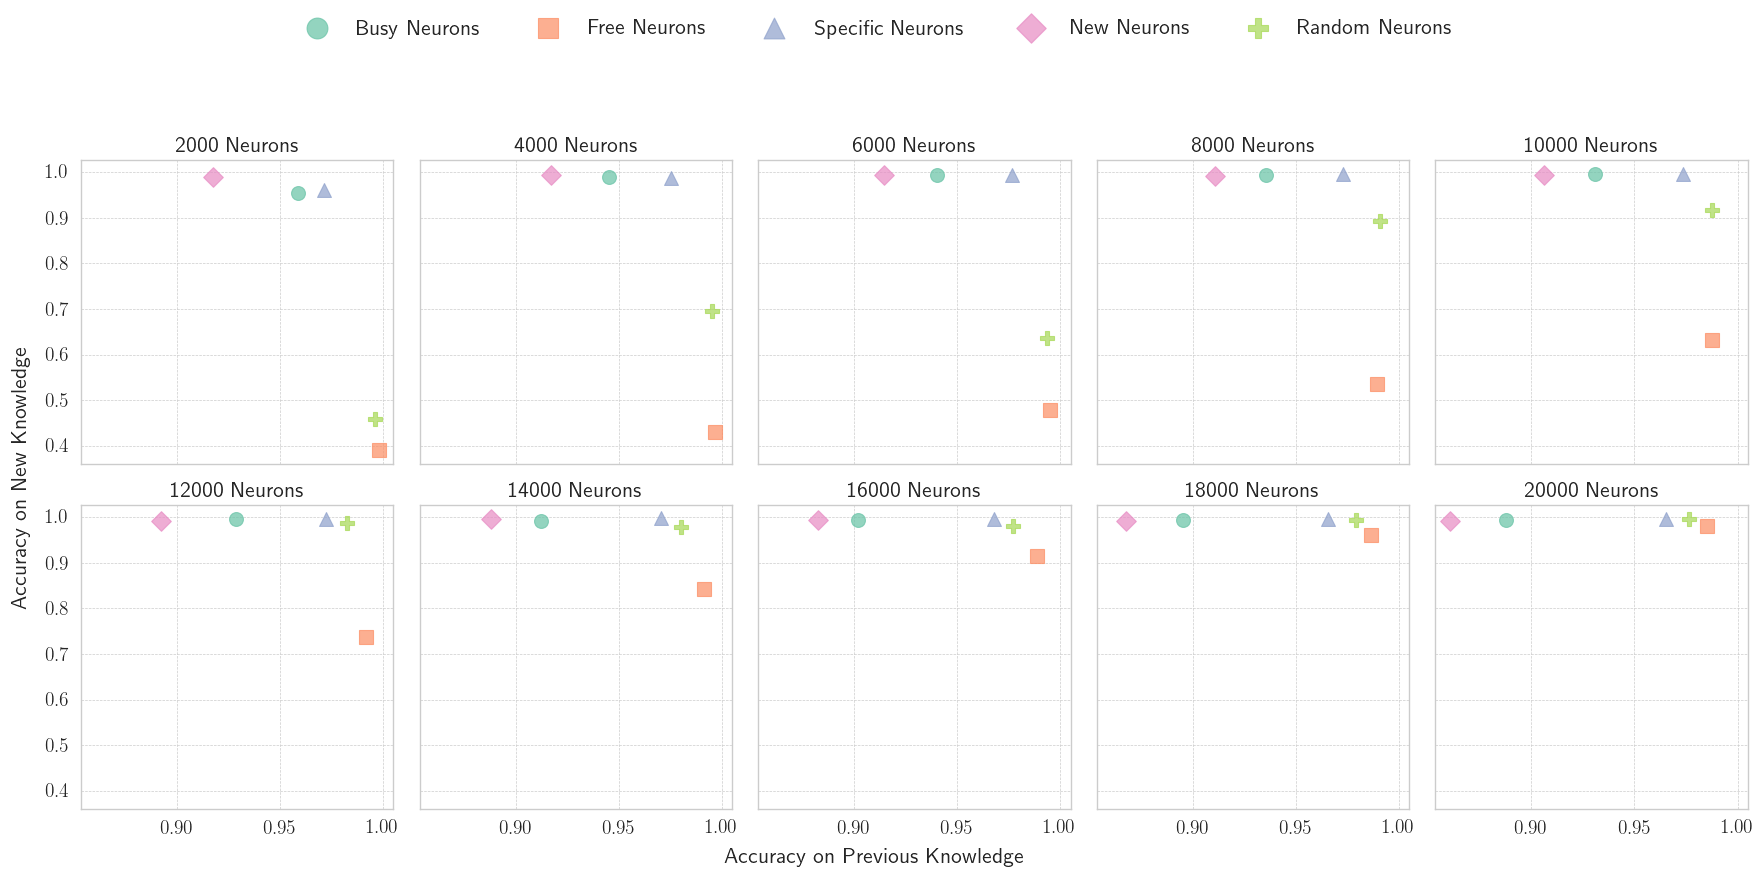

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

def plot_pareto_mosaic(filename, experiment_name, strategies=None, output_dir='.', figsize=(18, 8)):
    ## Set the matplotlib thing
    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'font.family': 'serif',
        'text.usetex': True,
        'figure.figsize': (8, 10)
    })
    # Define modular font sizes
    title_fontsize = 16
    label_fontsize = 16
    tick_fontsize = 14
    legend_fontsize = 16
    annotation_fontsize = 12
    
    # Load the data
    with open(filename, 'r') as file: 
        data = json.load(file)

    # Extract the number of folds and thresholds
    n_folds = len(data['results'].keys())
    thresholds = [int(t) for t in list(next(iter(data['results'].values()))['cftb'].keys())]

    # Define default strategies if none are provided
    default_strategies = ['busy_A', 'free_A', 'busy_H_spec', 'spec_B', 'busy_B', 'rnd']
    strategy_labels = {
        'busy_A': 'Busy Neurons',
        'free_A': 'Free Neurons',
        'busy_H_spec': 'Specific Neurons (General)',
        'spec_B': 'Specific Neurons',
        'busy_B': 'New Neurons',
        'rnd': 'Random Neurons'
    }

    # If no strategies provided, use the default ones
    if strategies is None:
        strategies = default_strategies

    # Initialize results dictionary
    results = {strategy: {'acc_A': [], 'acc_B': [], 'std_acc_A': [], 'std_acc_B': []} for strategy in strategies}

    # Baselines
    fta_accA = []
    ftb_accA = []
    ftb_accB = []

    # Aggregate results across folds
    for fold in data['results'].values():
        fta_accA.append(fold['fta']['acc_A'])
        ftb_accA.append(fold['ftb']['avg_accA'])
        ftb_accB.append(fold['ftb']['avg_accB'])

        for strategy in strategies:
            acc_A = []
            acc_B = []
            for t in thresholds:
                acc_A.append(fold['cftb'][str(t)][strategy]['avg_accA'])
                acc_B.append(fold['cftb'][str(t)][strategy]['avg_accB'])
            results[strategy]['acc_A'].append(acc_A)
            results[strategy]['acc_B'].append(acc_B)

    # Compute means and standard deviations
    for strategy in strategies:
        results[strategy]['mean_acc_A'] = np.mean(results[strategy]['acc_A'], axis=0)
        results[strategy]['mean_acc_B'] = np.mean(results[strategy]['acc_B'], axis=0)
        results[strategy]['std_acc_A'] = np.std(results[strategy]['acc_A'], axis=0)
        results[strategy]['std_acc_B'] = np.std(results[strategy]['acc_B'], axis=0)

    # Baseline means
    fta_accA_mean = np.mean(fta_accA)
    ftb_accA_mean = np.mean(ftb_accA)
    ftb_accB_mean = np.mean(ftb_accB)

    # Plotting
    sns.set(style="whitegrid", context="paper", font_scale=1.2)
    markers = ['o', 's', '^', 'D', 'P', '*']  # Example markers for each strategy
    palette = sns.color_palette("Set2", n_colors=len(strategies))

    fig, axes = plt.subplots(2, 5, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()

    for i, neurons in enumerate(thresholds):
        ax = axes[i]
        
        for idx, strategy in enumerate(strategies):
            ax.scatter(results[strategy]['mean_acc_A'][i], results[strategy]['mean_acc_B'][i], 
                       label=strategy_labels[strategy], color=palette[idx], s=100, alpha=0.7, marker=markers[idx])

        ax.set_title(f'{neurons} Neurons', fontsize=title_fontsize)
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    fig.text(0.5, 0.02, 'Accuracy on Previous Knowledge', ha='center', fontsize=label_fontsize)
    fig.text(0.02, 0.5, 'Accuracy on New Knowledge', va='center', rotation='vertical', fontsize=label_fontsize)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fontsize=legend_fontsize, markerscale=1.5)

    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])

    # Save the plot
    output_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(filename))[0]}_neuron_update_strategies_scatter.pdf")
    plt.savefig(output_path)
    plt.show()

experiment_name = 'experiment2_1_withB'
filepath = '../experiments/gpt2-small/experiment_2_1/results/'
filename = 'experiment_2_1_with_B_20240720_011953.json'

# Call the function to plot the Pareto mosaic
plot_pareto_mosaic(filename=os.path.join(filepath, filename), experiment_name=experiment_name, strategies = ['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'])


In [37]:
strategies

['busy_A', 'free_A', 'busy_H_spec', 'spec_B', 'busy_B', 'rnd']

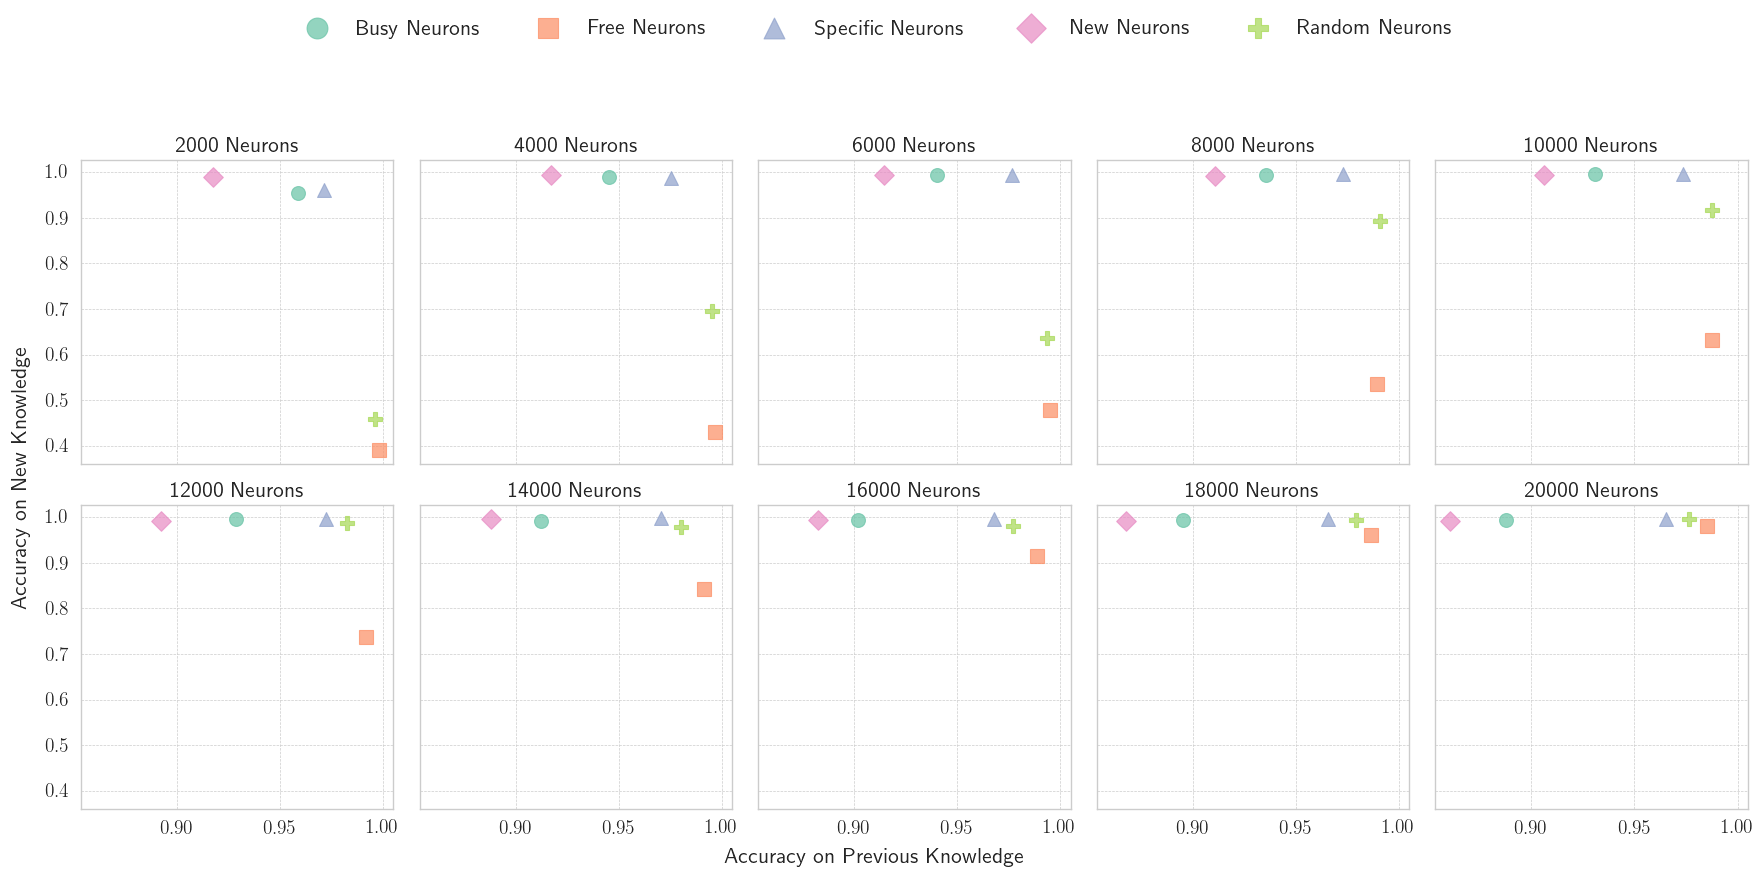

In [2]:
experiment_name = 'experiment2_1_withB'
filepath = '../experiments/gpt2-small/experiment_2_1/results/'
filename = 'experiment_2_1_with_B_20240720_011953.json'

# Call the function to plot the Pareto mosaic
plot_pareto_mosaic(filename=os.path.join(filepath, filename), experiment_name=experiment_name, strategies = ['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'])

#### 3D surface Pareto

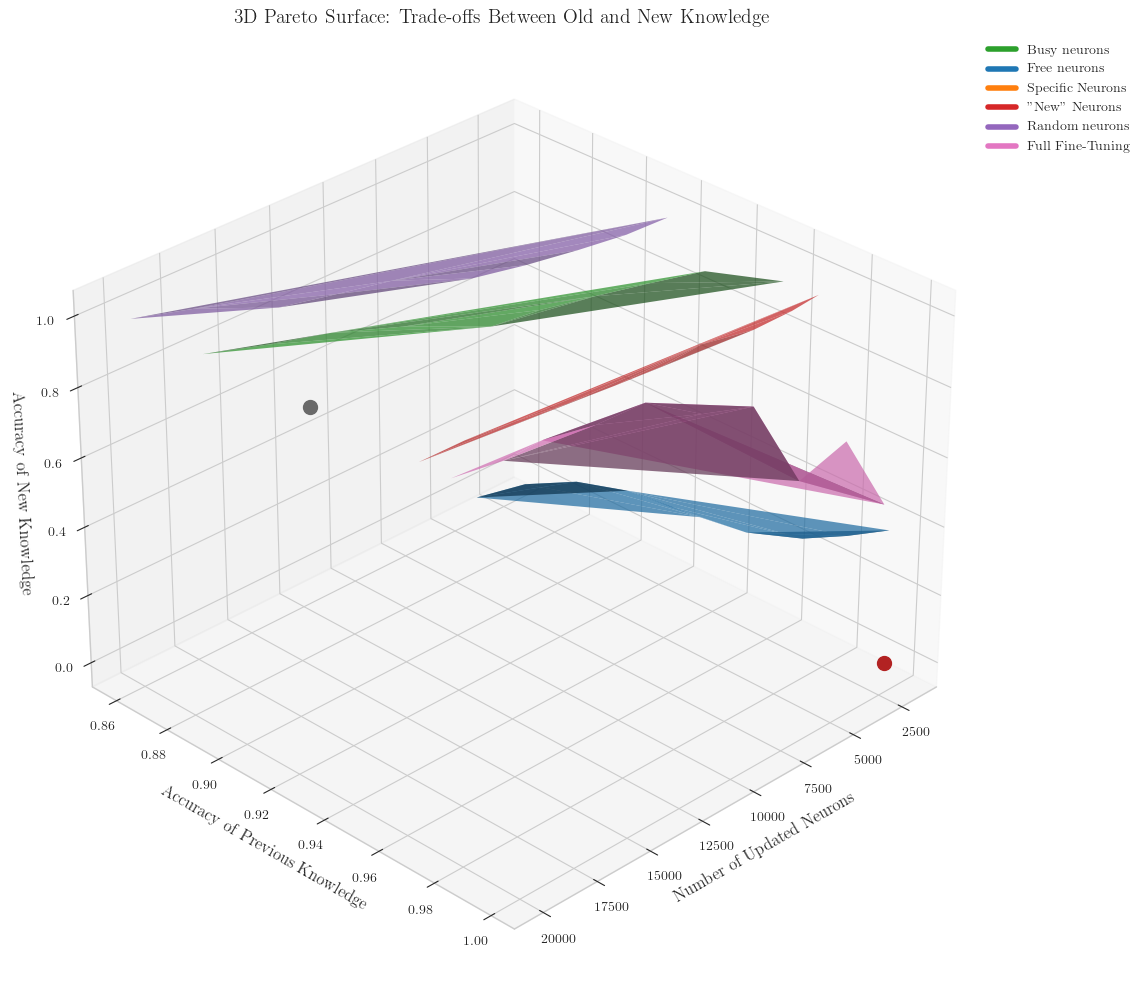

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.patches as mpatches
import json
import importlib
import os
import pickle

import sys
# custom path insertion
sys.path.append(os.path.abspath('..'))

import utils 
importlib.reload(utils)

experiment_name = 'experiment2_1_withB'

from utils import *

# Set up the plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (8, 10)
})

with open('../experiments/gpt2-small/experiment_2_1/results/experiment_2_1_with_B_20240720_011953.json', 'r') as file: 
    data = json.load(file)

# Assuming `data` contains the actual experimental data
n_folds =  len(data['results'].keys())
n_thresh = len(list(data['results'].values())[0]['cftb'].keys())

fta_accA = 0
ftb_accA = 0
ftb_accB = 0

# Arrays to store individual fold results for calculating std dev
fold_results_cftb_busy_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busy_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_free_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_free_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_inter_gen_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_inter_gen_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_specB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_specB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accB = np.zeros((n_folds, n_thresh))

for i, fold in enumerate(data['results']):
    fta_accA += data['results'][fold]['fta']['acc_A']

    ftb_accA += data['results'][fold]['ftb']['avg_accA']
    ftb_accB += data['results'][fold]['ftb']['avg_accB']

    cftb_results = data['results'][fold]['cftb']

    fold_results_cftb_busy_accA[i, :] = np.array([cftb_results[t]['busy_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busy_accB[i, :] = np.array([cftb_results[t]['busy_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_free_accA[i, :] = np.array([cftb_results[t]['free_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_free_accB[i, :] = np.array([cftb_results[t]['free_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_inter_gen_accA[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_inter_gen_accB[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_specB_accA[i, :] = np.array([cftb_results[t]['spec_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_specB_accB[i, :] = np.array([cftb_results[t]['spec_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyB_accA[i, :] = np.array([cftb_results[t]['busy_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyB_accB[i, :] = np.array([cftb_results[t]['busy_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accA[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accB[i, :] = np.array([cftb_results[t]['rnd']['avg_accB'] for t in cftb_results]).astype(float)

fta_accA /= n_folds
ftb_accA /= n_folds
ftb_accB /= n_folds

cftb_free_accA = np.mean(fold_results_cftb_free_accA, axis=0)
cftb_free_accB = np.mean(fold_results_cftb_free_accB, axis=0)
cftb_busy_accA = np.mean(fold_results_cftb_busy_accA, axis=0)
cftb_busy_accB = np.mean(fold_results_cftb_busy_accB, axis=0)
cftb_inter_gen_accA = np.mean(fold_results_cftb_inter_gen_accA, axis=0)
cftb_inter_gen_accB = np.mean(fold_results_cftb_inter_gen_accB, axis=0)
cftb_specB_accA = np.mean(fold_results_cftb_specB_accA, axis=0)
cftb_specB_accB = np.mean(fold_results_cftb_specB_accB, axis=0)
cftb_busyB_accA = np.mean(fold_results_cftb_busyB_accA, axis=0)
cftb_busyB_accB = np.mean(fold_results_cftb_busyB_accB, axis=0)
cftb_rnd_accA = np.mean(fold_results_cftb_rnd_accA, axis=0)
cftb_rnd_accB = np.mean(fold_results_cftb_rnd_accB, axis=0)

# Creating custom x labels
x_labels = list(cftb_results.keys())

# Plotting the 3D Pareto Surface
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Convert x_labels to integers (representing the number of neurons)
x = np.array([int(x) for x in x_labels])

# Create 3D surface plots for each strategy
ax.plot_trisurf(x, cftb_busy_accA, cftb_busy_accB, color='tab:green', alpha=0.7)
ax.plot_trisurf(x, cftb_free_accA, cftb_free_accB, color='tab:blue', alpha=0.7)
#ax.plot_trisurf(x, cftb_inter_gen_accA, cftb_inter_gen_accB, color='tab:orange', alpha=0.7)
ax.plot_trisurf(x, cftb_specB_accA, cftb_specB_accB, color='tab:red', alpha=0.7)
ax.plot_trisurf(x, cftb_busyB_accA, cftb_busyB_accB, color='tab:purple', alpha=0.7)
ax.plot_trisurf(x, cftb_rnd_accA, cftb_rnd_accB, color='tab:pink', alpha=0.7)

# Add initial and full fine-tuning baselines
ax.scatter([min(x)], [fta_accA], [0], color='firebrick', s=100)
ax.scatter([max(x)], [ftb_accA], [ftb_accB], color='dimgrey', s=100)

ax.set_xlabel('Number of Updated Neurons')
ax.set_ylabel('Accuracy of Previous Knowledge')
ax.set_zlabel('Accuracy of New Knowledge')
ax.set_title('3D Pareto Surface: Trade-offs Between Old and New Knowledge')

# Improving the appearance
ax.view_init(elev=30, azim=45)

# Create custom legend
custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4),
                Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:purple', lw=4),
                Line2D([0], [0], color='tab:pink', lw=4),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='firebrick', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='dimgrey', markersize=10)]

ax.legend(custom_lines, ['Busy neurons', 'Free neurons',  
                         'Specific Neurons', '"New" Neurons', 'Random neurons', 'Full Fine-Tuning'],
          loc='upper left', bbox_to_anchor=(1, 1))

# For publication-ready style
plt.tight_layout()
plt.show()

## Gradients distributions

MAX VALUE: 0.6019504070281982
MIN VALUE: -0.48599937558174133


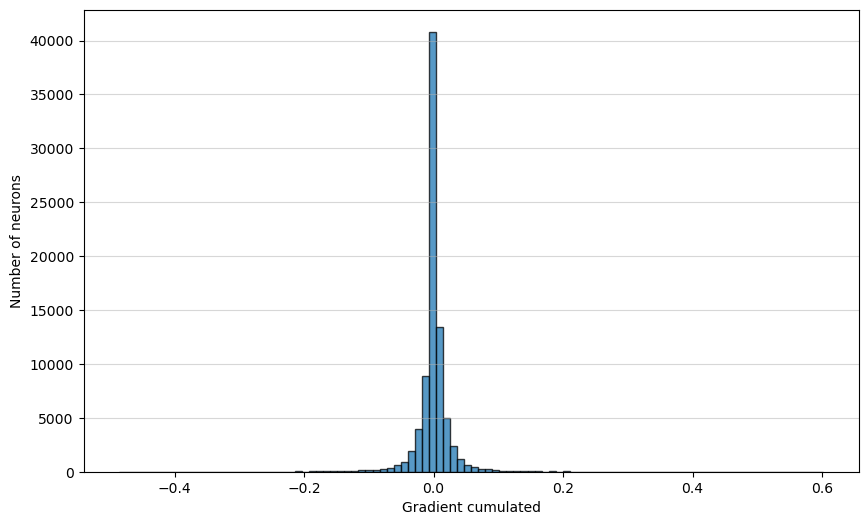

In [4]:
with open('../results/experiment_2_1/historical_dataA.pkl', 'rb') as file: 
    data = pickle.load(file)

grad_distr = np.array([])

for layer in data['grad_hist_dict']['raw']:
    grad_distr = np.concatenate((grad_distr, data['grad_hist_dict']['raw'][layer]))

print(f'MAX VALUE: {np.max(grad_distr)}')
print(f'MIN VALUE: {np.min(grad_distr)}')

# Plotting the distribution of the array
plt.figure(figsize=(10, 6))
plt.hist(grad_distr, bins=100, alpha=0.75, color='tab:blue', edgecolor='black')
# plt.title('Distribution of gradients cumulation')
plt.xlabel('Gradient cumulated')
plt.ylabel('Number of neurons')
plt.grid(axis='y', alpha=0.5)  # This makes the grid lines horizontal
plt.show()


#### Distribution of busy neurons across layers

0.9999999999999998


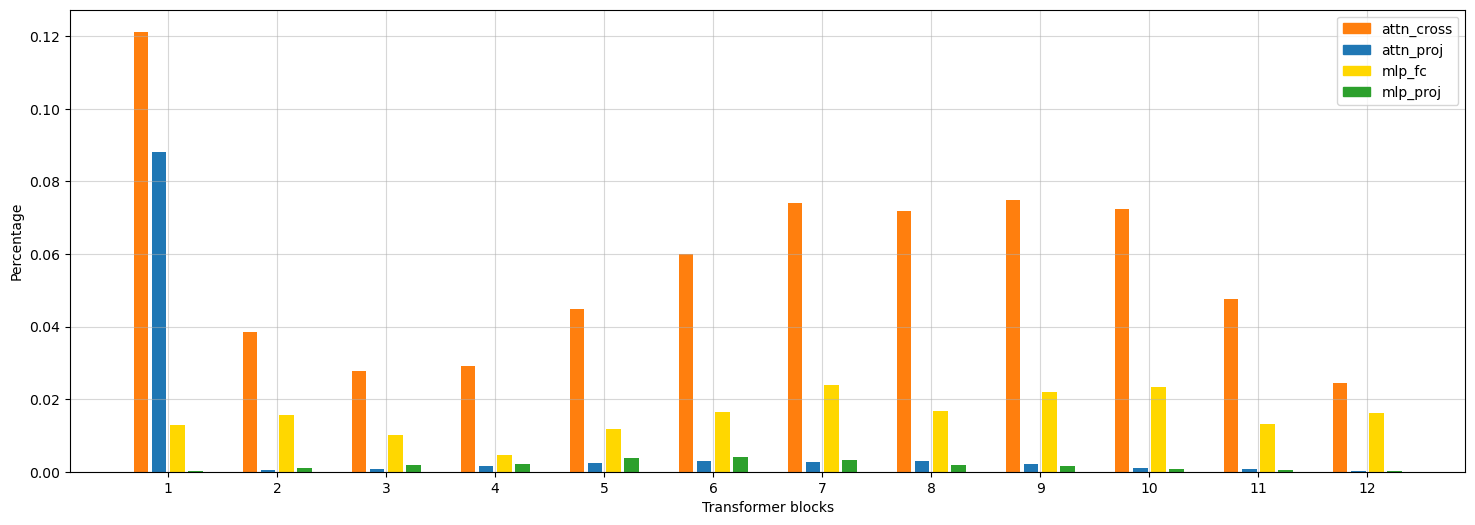

In [10]:
t=4000

# Sample dictionary with numpy arrays as values
data, num_neurons, count = stubborn_extraction(
    historical_path='../results/experiment_2_1/historical_dataA.pkl',
    norm=False,
    inverse=True,
    threshold=t,
    return_stubborn=False
    )


x_labels = [f"{k.split('.')[-2]}.{k.split('.')[-1]}.{k.split('.')[-3]}" for k in data.keys()]

# Extract the lengths of the numpy arrays
lengths = [(len(v[0])) / t for v in data.values()]

print(sum(lengths))

# Define the repeating color pattern
colors = ['tab:orange', 'tab:blue', 'gold', 'tab:green']
color_labels = ['attn_cross', 'attn_proj', 'mlp_fc', 'mlp_proj']

# Create the histogram
fig, ax = plt.subplots(1, 1, figsize=(18, 6), sharey=True)

# Define the new positions with larger gaps between groups
positions = []
gap = 2  # Increase the gap between groups
for i in range(len(lengths)):
    group = i // 4
    pos = i + group * gap  # Add a gap of 'gap' between groups
    positions.append(pos)

bars = ax.bar(positions, lengths, color=[colors[i % len(colors)] for i in range(len(lengths))])

# Add labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Transformer blocks')

# Set xticks to the center of each group
group_centers = [(1.5 + i * 4 + i * gap) for i in range(12)]
ax.set_xticks(group_centers)
ax.set_xticklabels([str(i + 1) for i in range(12)])

# Create legend
patches = [mpatches.Patch(color=colors[i], label=color_labels[i]) for i in range(len(colors))]
ax.legend(handles=patches)

# Add transparent grid
ax.grid(True, alpha=0.5)

# Display the plot
plt.show()

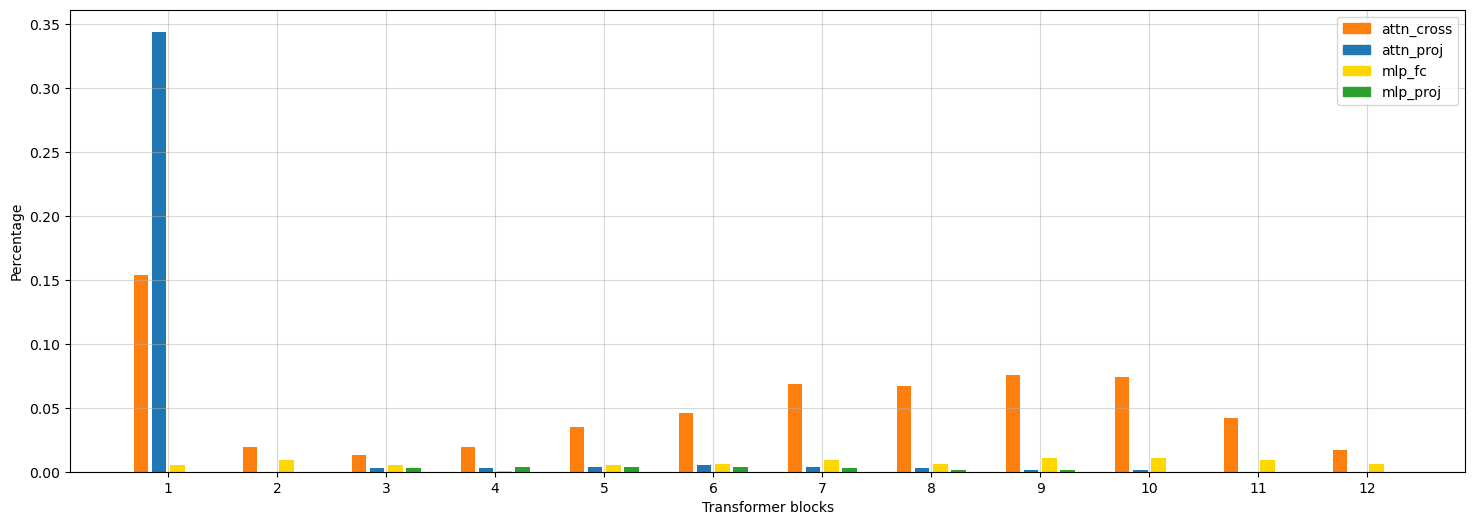

In [11]:
t=2000

# Sample dictionary with numpy arrays as values
data, num_neurons, count = stubborn_extraction(
    historical_path='../results/experiment_2_1/historical_dataA.pkl',
    norm=False,
    inverse=True,
    threshold=t,
    return_stubborn=False
    )


x_labels = [f"{k.split('.')[-2]}.{k.split('.')[-1]}.{k.split('.')[-3]}" for k in data.keys()]

# Extract the lengths of the numpy arrays
lengths = [(len(v[0])) / num_neurons[i] for i,v in enumerate(data.values())]

# Define the repeating color pattern
colors = ['tab:orange', 'tab:blue', 'gold', 'tab:green']
color_labels = ['attn_cross', 'attn_proj', 'mlp_fc', 'mlp_proj']

# Create the histogram
fig, ax = plt.subplots(1, 1, figsize=(18, 6), sharey=True)

# Define the new positions with larger gaps between groups
positions = []
gap = 2  # Increase the gap between groups
for i in range(len(lengths)):
    group = i // 4
    pos = i + group * gap  # Add a gap of 'gap' between groups
    positions.append(pos)

bars = ax.bar(positions, lengths, color=[colors[i % len(colors)] for i in range(len(lengths))])

# Add labels and title
ax.set_ylabel('Percentage')
ax.set_xlabel('Transformer blocks')

# Set xticks to the center of each group
group_centers = [(1.5 + i * 4 + i * gap) for i in range(12)]
ax.set_xticks(group_centers)
ax.set_xticklabels([str(i + 1) for i in range(12)])

# Create legend
patches = [mpatches.Patch(color=colors[i], label=color_labels[i]) for i in range(len(colors))]
ax.legend(handles=patches)

# Add transparent grid
ax.grid(True, alpha=0.5)

# Display the plot
plt.show()

In [4]:
t=8000

# Sample dictionary with numpy arrays as values
busy_H, _, _ = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2_3/historical_data_gen.pkl',
    norm=False,
    threshold=0,
    inverse=True,
    num_threshold=t,
    return_stubborn=False
    )

# Sample dictionary with numpy arrays as values
busy_A, _, _ = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2_3/historical_data.pkl',
    norm=False,
    threshold=0,
    inverse=True,
    num_threshold=t,
    return_stubborn=False
    )


# Sample dictionary with numpy arrays as values
spec_busy_A, _, _ = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2_3/historical_data.pkl',
    norm=True,
    threshold=0,
    inverse=True,
    num_threshold=t,
    return_stubborn=False
    )


# Sample dictionary with numpy arrays as values
free_H, _, _ = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2_3/historical_data_gen.pkl',
    norm=False,
    threshold=0,
    inverse=False,
    num_threshold=t,
    return_stubborn=False
    )

# Sample dictionary with numpy arrays as values
free_A, _, _ = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2_3/historical_data.pkl',
    norm=False,
    threshold=0,
    inverse=False,
    num_threshold=t,
    return_stubborn=False
    )


# Sample dictionary with numpy arrays as values
spec_free_A, _, _ = stubborn_extraction(
    historical_path='../experiments/gpt2-small/experiment_2_3/historical_data.pkl',
    norm=True,
    threshold=0,
    inverse=False,
    num_threshold=t,
    return_stubborn=False
    )

print(len(busy_A['transformer.h.0.attn.c_attn']))


tot = 0
for layer in spec_free_A:
    print(f'LAYER: {layer} - {len(spec_busy_A[layer][0])} elements')
    a = np.intersect1d(spec_free_A[layer][0], free_A[layer][0])
    b = np.intersect1d(spec_free_A[layer][0], free_H[layer][0])
    c = np.intersect1d(spec_free_A[layer][0], busy_A[layer][0])
    d = np.intersect1d(spec_free_A[layer][0], busy_H[layer][0])
    
    e = np.intersect1d(spec_busy_A[layer][0], free_A[layer][0])
    f = np.intersect1d(spec_busy_A[layer][0], free_H[layer][0])
    g = np.intersect1d(spec_busy_A[layer][0], busy_A[layer][0])
    h = np.intersect1d(spec_busy_A[layer][0], busy_H[layer][0])

    f = np.intersect1d(busy_A[layer][0], busy_H[layer][0])


    mid_AF = 1 - (len(a)+len(c))/(len(spec_free_A[layer][0])+1e-6)
    mid_HF = 1 - ((len(b)+len(d)))/(len(spec_free_A[layer][0])+1e-6)

    mid_AB = 1 - (len(e)+len(g))/(len(spec_busy_A[layer][0])+1e-6)
    mid_HB = 1 - ((len(f)+len(h)))/(len(spec_busy_A[layer][0])+1e-6)
    
    print(f'Overlapping spec_free_A-free_A: {len(a)/(len(spec_free_A[layer][0])+1e-6)}')
    print(f'Overlapping spec_free_A-free_H: {len(b)/(len(spec_free_A[layer][0])+1e-6)}')
    print(f'Overlapping spec_free_A-busy_A: {len(c)/(len(spec_free_A[layer][0])+1e-6)}')
    print(f'Overlapping spec_free_A-busy_H: {len(d)/(len(spec_free_A[layer][0])+1e-6)}')
    print(f'MID A: {mid_AF} - MID H:{mid_HF}')

    print(f'Overlapping spec_busy_A-free_A: {len(e)/(len(spec_busy_A[layer][0])+1e-6)}')
    print(f'Overlapping spec_busy_A-free_H: {len(f)/(len(spec_busy_A[layer][0])+1e-6)}')
    print(f'Overlapping spec_busy_A-busy_A: {len(g)/(len(spec_busy_A[layer][0])+1e-6)}')
    print(f'Overlapping spec_busy_A-busy_H: {len(h)/(len(spec_busy_A[layer][0])+1e-6)}')
    print(f'MID A: {mid_AB} - MID H:{mid_HB}')
    tot+=len(f)

    print()

print()
print(tot/t)

TypeError: stubborn_extraction() got an unexpected keyword argument 'num_threshold'

## Old accuracy plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import importlib
import os
import pickle
import sys
# custom path insertion
sys.path.append(os.path.abspath('..'))
import utils 
importlib.reload(utils)
from utils import *

experiment_name = 'experiment2_1_withB'
filepath = '../experiments/gpt2-small/experiment_2_1/results/'
filename = 'experiment_2_1_with_B_20240720_011953.json'

def plot_old_new_knowledge_all(filename,experiment_name):
    # Set up the plot style
    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'font.family': 'serif',
        'text.usetex': True,
        'figure.figsize': (8, 10)
    })
    with open(os.path.join(filepath, filename), 'r') as file: 
        data = json.load(file)
    output_dir = f"./figures/{experiment_name}"
    os.makedirs(output_dir, exist_ok=True)

    # Assuming `data` contains the actual experimental data
    n_folds =  len(data['results'].keys())
    n_thresh = len(list(data['results'].values())[0]['cftb'].keys())

    fta_accA = 0
    ftb_accA = 0
    ftb_accB = 0

    # Arrays to store individual fold results for calculating std dev
    fold_results_cftb_busy_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busy_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_free_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_free_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_inter_gen_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_inter_gen_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_specB_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_specB_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busyB_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_busyB_accB = np.zeros((n_folds, n_thresh))
    fold_results_cftb_rnd_accA = np.zeros((n_folds, n_thresh))
    fold_results_cftb_rnd_accB = np.zeros((n_folds, n_thresh))

    for i, fold in enumerate(data['results']):
        fta_accA += data['results'][fold]['fta']['acc_A']

        ftb_accA += data['results'][fold]['ftb']['avg_accA']
        ftb_accB += data['results'][fold]['ftb']['avg_accB']

        cftb_results = data['results'][fold]['cftb']

        fold_results_cftb_busy_accA[i, :] = np.array([cftb_results[t]['busy_A']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_busy_accB[i, :] = np.array([cftb_results[t]['busy_A']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_free_accA[i, :] = np.array([cftb_results[t]['free_A']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_free_accB[i, :] = np.array([cftb_results[t]['free_A']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_inter_gen_accA[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_inter_gen_accB[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_specB_accA[i, :] = np.array([cftb_results[t]['spec_B']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_specB_accB[i, :] = np.array([cftb_results[t]['spec_B']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_busyB_accA[i, :] = np.array([cftb_results[t]['busy_B']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_busyB_accB[i, :] = np.array([cftb_results[t]['busy_B']['avg_accB'] for t in cftb_results]).astype(float)
        fold_results_cftb_rnd_accA[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)
        fold_results_cftb_rnd_accB[i, :] = np.array([cftb_results[t]['rnd']['avg_accB'] for t in cftb_results]).astype(float)

    fta_accA /= n_folds
    ftb_accA /= n_folds
    ftb_accB /= n_folds

    cftb_free_accA = np.mean(fold_results_cftb_free_accA, axis=0)
    cftb_free_accB = np.mean(fold_results_cftb_free_accB, axis=0)
    cftb_busy_accA = np.mean(fold_results_cftb_busy_accA, axis=0)
    cftb_busy_accB = np.mean(fold_results_cftb_busy_accB, axis=0)
    cftb_inter_gen_accA = np.mean(fold_results_cftb_inter_gen_accA, axis=0)
    cftb_inter_gen_accB = np.mean(fold_results_cftb_inter_gen_accB, axis=0)
    cftb_specB_accA = np.mean(fold_results_cftb_specB_accA, axis=0)
    cftb_specB_accB = np.mean(fold_results_cftb_specB_accB, axis=0)
    cftb_busyB_accA = np.mean(fold_results_cftb_busyB_accA, axis=0)
    cftb_busyB_accB = np.mean(fold_results_cftb_busyB_accB, axis=0)
    cftb_rnd_accA = np.mean(fold_results_cftb_rnd_accA, axis=0)
    cftb_rnd_accB = np.mean(fold_results_cftb_rnd_accB, axis=0)

    # Calculate standard deviation
    std_cftb_busy_accA = np.std(fold_results_cftb_busy_accA, axis=0)
    std_cftb_busy_accB = np.std(fold_results_cftb_busy_accB, axis=0)
    std_cftb_free_accA = np.std(fold_results_cftb_free_accA, axis=0)
    std_cftb_free_accB = np.std(fold_results_cftb_free_accB, axis=0)
    std_cftb_inter_gen_accA = np.std(fold_results_cftb_inter_gen_accA, axis=0)
    std_cftb_inter_gen_accB = np.std(fold_results_cftb_inter_gen_accB, axis=0)
    std_cftb_specB_accA = np.std(fold_results_cftb_specB_accA, axis=0)
    std_cftb_specB_accB = np.std(fold_results_cftb_specB_accB, axis=0)
    std_cftb_busyB_accA = np.std(fold_results_cftb_busyB_accA, axis=0)
    std_cftb_busyB_accB = np.std(fold_results_cftb_busyB_accB, axis=0)
    std_cftb_rnd_accA = np.std(fold_results_cftb_rnd_accA, axis=0)
    std_cftb_rnd_accB = np.std(fold_results_cftb_rnd_accB, axis=0)

    # Creating custom x labels
    x_labels = list(cftb_results.keys())

    # Plot - Accuracy of Previous Knowledge
    plt.figure(figsize=(12, 6))
    plt.axhline(y=fta_accA, color='firebrick', linestyle='solid', linewidth=1.5, alpha=0.80, label='Initial')
    plt.axhline(y=ftb_accA, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
    ## for x in strategy_accB : pick only the ones selected 
    plt.errorbar(x_labels, cftb_busy_accA, yerr=std_cftb_busy_accA, linestyle='--', linewidth=1.5, color='tab:green', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Busy neurons')
    plt.errorbar(x_labels, cftb_free_accA, yerr=std_cftb_free_accA, linestyle='-', linewidth=1.5, color='tab:blue', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Free neurons')
    plt.errorbar(x_labels, cftb_inter_gen_accA, yerr=std_cftb_inter_gen_accA, linestyle='-.', linewidth=1.5, color='tab:orange', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (General)')
    plt.errorbar(x_labels, cftb_specB_accA, yerr=std_cftb_specB_accA, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (New)')
    plt.errorbar(x_labels, cftb_busyB_accA, yerr=std_cftb_busyB_accA, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='New Neurons (New)')
    plt.errorbar(x_labels, cftb_rnd_accA, yerr=std_cftb_rnd_accA, linestyle=':', linewidth=1.5, color='tab:purple', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
    plt.xlabel('Number of updated neurons')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    #plt.title('Accuracy of Previous Knowledge')
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{output_dir}/{filename[:-5]}_neuron_update_strategies_old_knowledge.pdf", format='pdf', bbox_inches='tight')

    # Plot - Accuracy of New Knowledge
    plt.figure(figsize=(12, 6))
    plt.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
    ## for x in strategy_accB : pick only the ones selected
    plt.errorbar(x_labels, cftb_busy_accB, yerr=std_cftb_busy_accB, linestyle='--', linewidth=1.5, color='tab:green', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Busy neurons')
    plt.errorbar(x_labels, cftb_free_accB, yerr=std_cftb_free_accB, linestyle='-', linewidth=1.5, color='tab:blue', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Free neurons')
    plt.errorbar(x_labels, cftb_inter_gen_accB, yerr=std_cftb_inter_gen_accB, linestyle='-.', linewidth=1.5, color='tab:orange', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (General)')
    plt.errorbar(x_labels, cftb_specB_accB, yerr=std_cftb_specB_accB, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (New)')
    plt.errorbar(x_labels, cftb_busyB_accB, yerr=std_cftb_busyB_accB, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='New Neurons (New)')
    plt.errorbar(x_labels, cftb_rnd_accB, yerr=std_cftb_rnd_accB, linestyle=':', linewidth=1.5, color='tab:purple', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
    plt.xlabel('Number of updated neurons')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    #plt.title('Accuracy of New Knowledge')
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{output_dir}/{filename[:-5]}_neuron_update_strategies_new_knowledge.pdf", format='pdf', bbox_inches='tight')

plot_old_new_knowledge_all(filename,experiment_name)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import importlib
import os
import pickle

import sys
# custom path insertion
sys.path.append(os.path.abspath('..'))

import utils 
importlib.reload(utils)

experiment_name = 'experiment2_1_withB'

from utils import *

# Set up the plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (8, 10)
})

with open('../experiments/gpt2-small/experiment_2_1/results/experiment_2_1_with_B_20240720_011953.json', 'r') as file: 
    data = json.load(file)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
experiment_name = "neuron_update_strategies"
output_dir = f"./figures/{experiment_name}"
os.makedirs(output_dir, exist_ok=True)

# Assuming `data` contains the actual experimental data
n_folds =  len(data['results'].keys())
n_thresh = len(list(data['results'].values())[0]['cftb'].keys())

fta_accA = 0
ftb_accA = 0
ftb_accB = 0

# Arrays to store individual fold results for calculating std dev
fold_results_cftb_busy_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busy_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_free_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_free_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_inter_gen_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_inter_gen_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_specB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_specB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyB_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busyB_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accB = np.zeros((n_folds, n_thresh))

for i, fold in enumerate(data['results']):
    fta_accA += data['results'][fold]['fta']['acc_A']

    ftb_accA += data['results'][fold]['ftb']['avg_accA']
    ftb_accB += data['results'][fold]['ftb']['avg_accB']

    cftb_results = data['results'][fold]['cftb']

    fold_results_cftb_busy_accA[i, :] = np.array([cftb_results[t]['busy_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busy_accB[i, :] = np.array([cftb_results[t]['busy_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_free_accA[i, :] = np.array([cftb_results[t]['free_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_free_accB[i, :] = np.array([cftb_results[t]['free_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_inter_gen_accA[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_inter_gen_accB[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_specB_accA[i, :] = np.array([cftb_results[t]['spec_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_specB_accB[i, :] = np.array([cftb_results[t]['spec_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyB_accA[i, :] = np.array([cftb_results[t]['busy_B']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busyB_accB[i, :] = np.array([cftb_results[t]['busy_B']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accA[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accB[i, :] = np.array([cftb_results[t]['rnd']['avg_accB'] for t in cftb_results]).astype(float)

fta_accA /= n_folds
ftb_accA /= n_folds
ftb_accB /= n_folds

cftb_free_accA = np.mean(fold_results_cftb_free_accA, axis=0)
cftb_free_accB = np.mean(fold_results_cftb_free_accB, axis=0)
cftb_busy_accA = np.mean(fold_results_cftb_busy_accA, axis=0)
cftb_busy_accB = np.mean(fold_results_cftb_busy_accB, axis=0)
cftb_inter_gen_accA = np.mean(fold_results_cftb_inter_gen_accA, axis=0)
cftb_inter_gen_accB = np.mean(fold_results_cftb_inter_gen_accB, axis=0)
cftb_specB_accA = np.mean(fold_results_cftb_specB_accA, axis=0)
cftb_specB_accB = np.mean(fold_results_cftb_specB_accB, axis=0)
cftb_busyB_accA = np.mean(fold_results_cftb_busyB_accA, axis=0)
cftb_busyB_accB = np.mean(fold_results_cftb_busyB_accB, axis=0)
cftb_rnd_accA = np.mean(fold_results_cftb_rnd_accA, axis=0)
cftb_rnd_accB = np.mean(fold_results_cftb_rnd_accB, axis=0)

# Calculate standard deviation
std_cftb_busy_accA = np.std(fold_results_cftb_busy_accA, axis=0)
std_cftb_busy_accB = np.std(fold_results_cftb_busy_accB, axis=0)
std_cftb_free_accA = np.std(fold_results_cftb_free_accA, axis=0)
std_cftb_free_accB = np.std(fold_results_cftb_free_accB, axis=0)
std_cftb_inter_gen_accA = np.std(fold_results_cftb_inter_gen_accA, axis=0)
std_cftb_inter_gen_accB = np.std(fold_results_cftb_inter_gen_accB, axis=0)
std_cftb_specB_accA = np.std(fold_results_cftb_specB_accA, axis=0)
std_cftb_specB_accB = np.std(fold_results_cftb_specB_accB, axis=0)
std_cftb_busyB_accA = np.std(fold_results_cftb_busyB_accA, axis=0)
std_cftb_busyB_accB = np.std(fold_results_cftb_busyB_accB, axis=0)
std_cftb_rnd_accA = np.std(fold_results_cftb_rnd_accA, axis=0)
std_cftb_rnd_accB = np.std(fold_results_cftb_rnd_accB, axis=0)

# Creating custom x labels
x_labels = list(cftb_results.keys())

# Plot - Accuracy of Previous Knowledge
plt.figure(figsize=(12, 6))
plt.axhline(y=fta_accA, color='firebrick', linestyle='solid', linewidth=1.5, alpha=0.80, label='Initial')
plt.axhline(y=ftb_accA, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
plt.errorbar(x_labels, cftb_busy_accA, yerr=std_cftb_busy_accA, linestyle='--', linewidth=1.5, color='tab:green', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Busy neurons')
plt.errorbar(x_labels, cftb_free_accA, yerr=std_cftb_free_accA, linestyle='-', linewidth=1.5, color='tab:blue', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Free neurons')
plt.errorbar(x_labels, cftb_inter_gen_accA, yerr=std_cftb_inter_gen_accA, linestyle='-.', linewidth=1.5, color='tab:orange', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (General)')
plt.errorbar(x_labels, cftb_specB_accA, yerr=std_cftb_specB_accA, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (New)')
plt.errorbar(x_labels, cftb_busyB_accA, yerr=std_cftb_busyB_accA, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='New Neurons (New)')
plt.errorbar(x_labels, cftb_rnd_accA, yerr=std_cftb_rnd_accA, linestyle=':', linewidth=1.5, color='tab:purple', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
plt.xlabel('Number of updated neurons')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Accuracy of Previous Knowledge')
plt.tight_layout()
plt.show()

# Plot - Accuracy of New Knowledge
plt.figure(figsize=(12, 6))
plt.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
plt.errorbar(x_labels, cftb_busy_accB, yerr=std_cftb_busy_accB, linestyle='--', linewidth=1.5, color='tab:green', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Busy neurons')
plt.errorbar(x_labels, cftb_free_accB, yerr=std_cftb_free_accB, linestyle='-', linewidth=1.5, color='tab:blue', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Free neurons')
plt.errorbar(x_labels, cftb_inter_gen_accB, yerr=std_cftb_inter_gen_accB, linestyle='-.', linewidth=1.5, color='tab:orange', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (General)')
plt.errorbar(x_labels, cftb_specB_accB, yerr=std_cftb_specB_accB, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Specific Neurons (New)')
plt.errorbar(x_labels, cftb_busyB_accB, yerr=std_cftb_busyB_accB, linestyle='-', linewidth=1.5, color='tab:red', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='New Neurons (New)')
plt.errorbar(x_labels, cftb_rnd_accB, yerr=std_cftb_rnd_accB, linestyle=':', linewidth=1.5, color='tab:purple', marker='o', capsize=3, elinewidth=1.5, capthick=1.5, label='Sparse neurons (random)')
plt.xlabel('Number of updated neurons')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Accuracy of New Knowledge')
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/neuron_update_strategies.pdf", format='pdf', bbox_inches='tight')
plt.close(fig)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_folds =  len(data['results'].keys())
n_thresh = len(list(data['results'].values())[0]['cftb'].keys())

fta_accA = 0
ftb_accA = 0
ftb_accB = 0

# Arrays to store individual fold results for calculating std dev
fold_results_cftb_busy_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_busy_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_free_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_free_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_inter_gen_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_inter_gen_accB = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accA = np.zeros((n_folds, n_thresh))
fold_results_cftb_rnd_accB = np.zeros((n_folds, n_thresh))

for i, fold in enumerate(data['results']):
    fta_accA += data['results'][fold]['fta']['acc_A']

    ftb_accA += data['results'][fold]['ftb']['avg_accA']
    ftb_accB += data['results'][fold]['ftb']['avg_accB']

    cftb_results = data['results'][fold]['cftb']

    fold_results_cftb_busy_accA[i, :] = np.array([cftb_results[t]['busy_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_busy_accB[i, :] = np.array([cftb_results[t]['busy_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_free_accA[i, :] = np.array([cftb_results[t]['free_A']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_free_accB[i, :] = np.array([cftb_results[t]['free_A']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_inter_gen_accA[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_inter_gen_accB[i, :] = np.array([cftb_results[t]['busy_H_spec']['avg_accB'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accA[i, :] = np.array([cftb_results[t]['rnd']['avg_accA'] for t in cftb_results]).astype(float)
    fold_results_cftb_rnd_accB[i, :] = np.array([cftb_results[t]['rnd']['avg_accB'] for t in cftb_results]).astype(float)

fta_accA /= n_folds
ftb_accA /= n_folds
ftb_accB /= n_folds

cftb_free_accA = np.mean(fold_results_cftb_free_accA, axis=0)
cftb_free_accB = np.mean(fold_results_cftb_free_accB, axis=0)
cftb_busy_accA = np.mean(fold_results_cftb_busy_accA, axis=0)
cftb_busy_accB = np.mean(fold_results_cftb_busy_accB, axis=0)
cftb_inter_gen_accA = np.mean(fold_results_cftb_inter_gen_accA, axis=0)
cftb_inter_gen_accB = np.mean(fold_results_cftb_inter_gen_accB, axis=0)
cftb_rnd_accA = np.mean(fold_results_cftb_rnd_accA, axis=0)
cftb_rnd_accB = np.mean(fold_results_cftb_rnd_accB, axis=0)

# Calculate standard deviation
std_cftb_busy_accA = np.std(fold_results_cftb_busy_accA, axis=0)
std_cftb_busy_accB = np.std(fold_results_cftb_busy_accB, axis=0)
std_cftb_free_accA = np.std(fold_results_cftb_free_accA, axis=0)
std_cftb_free_accB = np.std(fold_results_cftb_free_accB, axis=0)
std_cftb_inter_gen_accA = np.std(fold_results_cftb_inter_gen_accA, axis=0)
std_cftb_inter_gen_accB = np.std(fold_results_cftb_inter_gen_accB, axis=0)
std_cftb_rnd_accA = np.std(fold_results_cftb_rnd_accA, axis=0)
std_cftb_rnd_accB = np.std(fold_results_cftb_rnd_accB, axis=0)

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Creating custom x labels
x_labels = list(cftb_results.keys())

# First subplot
axs.axhline(y=fta_accA, color='firebrick', linestyle='solid', linewidth=1.5, alpha=0.80, label='Initial')
axs.axhline(y=ftb_accA, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
axs.errorbar(x_labels, cftb_busy_accA, yerr=std_cftb_busy_accA, linestyle='--', linewidth=1.5, color='tab:green', marker='.', capsize=2, elinewidth=1, capthick=1, label='Busy neurons')
axs.errorbar(x_labels, cftb_free_accA, yerr=std_cftb_free_accA, linestyle='-', linewidth=1.5, color='tab:blue', marker='.', capsize=2, elinewidth=1, capthick=1, label='Free neurons')
axs.errorbar(x_labels, cftb_inter_gen_accA, yerr=std_cftb_inter_gen_accA, linestyle='-.',linewidth=1.5, color='tab:orange', marker='.', capsize=2, elinewidth=1, capthick=1, label='Specific neurons')
axs.errorbar(x_labels, cftb_rnd_accA, yerr=std_cftb_rnd_accA, linestyle=':', linewidth=1.5, color='tab:purple', marker='.', capsize=2, elinewidth=1, capthick=1, label='Sparse neurons (random)')
axs.set_xlabel('Number of updated neurons')
axs.set_ylabel('Accuracy')
#axs.set_title('Sequential learning experiment - Accuracy of Previous Knowledge')
axs.legend(loc='lower right')
axs.grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Second subplot
axs.axhline(y=ftb_accB, color='dimgrey', linestyle='solid', linewidth=1.5, alpha=0.80, label='Full fine-tuning')
axs.errorbar(x_labels, cftb_busy_accB, yerr=std_cftb_busy_accB, linestyle='--', linewidth=1.5, color='tab:green', marker='.', capsize=2, elinewidth=1, capthick=1, label='Busy neurons')
axs.errorbar(x_labels, cftb_free_accB, yerr=std_cftb_free_accB, linestyle='-', linewidth=1.5, color='tab:blue', marker='.', capsize=2, elinewidth=1, capthick=1, label='Free neurons')
axs.errorbar(x_labels, cftb_inter_gen_accB, yerr=std_cftb_inter_gen_accB, linestyle='-.', linewidth=1.5, color='tab:orange', marker='.', capsize=2, elinewidth=1, capthick=1, label='Specific neurons')
axs.errorbar(x_labels, cftb_rnd_accB, yerr=std_cftb_rnd_accB, linestyle=':', linewidth=1.5, color='tab:purple', marker='.', capsize=2, elinewidth=1, capthick=1, label='Sparse neurons (random)')
axs.set_xlabel('Number of updated neurons')
axs.set_ylabel('Accuracy')
#axs.set_title('Sequential learning experiment - Accuracy of New Knowledge')
axs.legend(loc='lower right')
axs.grid(True)

plt.tight_layout()
plt.show()